In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt
from datetime import datetime

2023-12-14 05:55:49.325744: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  print('nop')

2023-12-14 05:55:50.709206: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-14 05:55:50.710034: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-12-14 05:55:50.725769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-14 05:55:50.725952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2023-12-14 05:55:50.725967: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-12-14 05:55:50.727531: I tensorflow/stream_executor/platform/defa

In [3]:
# Define parameters
input_shape = (128, 128, 3)  # Adjust based on your dataset
batch_size = 64
num_classes = 50
epoch = 200

# train_data_dir = './Dataset/BanglaLekha-Isolated/BanglaLekha-Isolated/Images/'
train_data_dir = './Dataset/b/Train/'
# test_data_dir = './dataset/RESIZED_TESTING_DATA'

# Create data generators with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2  # 20% of the data will be used for validationfrom datetime import datetime
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    # color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set this to 'validation' for the validation set
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    # color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set this to 'training' for the training set
)

# Define a function to create a model with a specific base model
def create_transfer_model(base_model):
    base_model.trainable = False  # Freeze pre-trained layers
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x) #layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

# List of base models to try
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    


Found 9600 images belonging to 50 classes.
Found 2400 images belonging to 50 classes.


2023-12-14 05:55:51.410768: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 05:55:51.411161: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-14 05:55:51.411302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-14 05:55:51.411599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB

In [4]:
model = create_transfer_model(base_model)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [5]:
initial_strength = 0.01
final_strength = 0.0001
decay_epochs = 10


class DynamicRegularizationCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_strength, final_strength, decay_epochs):
        super(DynamicRegularizationCallback, self).__init__()
        self.initial_strength = initial_strength
        self.final_strength = final_strength
        self.decay_epochs = decay_epochs

    def on_epoch_end(self, epoch, logs=None):
        dynamic_strength = self.initial_strength - (epoch / self.decay_epochs) * (self.initial_strength - self.final_strength)
        tf.keras.backend.set_value(self.model.dynamic_strength, dynamic_strength)

# Create an instance of the callback
dynamic_regularization_callback = DynamicRegularizationCallback(initial_strength, final_strength, decay_epochs)

# Adjust the custom loss function to take epoch as an argument
def custom_loss_with_dynamic_regularization(epoch):
    def loss_function(y_true, y_pred):
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        l2_regularization = tf.keras.backend.get_value(model.dynamic_strength) * tf.reduce_sum([tf.reduce_sum(tf.square(w)) for w in model.trainable_weights])
        total_loss = cross_entropy + l2_regularization
        return total_loss

    return loss_function

# Create a placeholder for dynamic_strength in the model
model.dynamic_strength = tf.Variable(0.0, trainable=False)


2023-12-14 05:55:52.578593: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-12-14 05:55:52.578614: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-12-14 05:55:52.578642: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-12-14 05:55:52.579315: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-12-14 05:55:52.679684: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-12-14 05:55:52.679827: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-12-14 05:55:52.872512: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-12-14 05:55

Epoch 1/200


2023-12-14 05:55:53.460278: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-12-14 05:55:53.651355: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-12-14 05:55:54.708005: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-12-14 05:55:54.752692: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  2/150 [..............................] - ETA: 14s - loss: 9.2656 - accuracy: 0.0039      

2023-12-14 05:56:02.209519: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-12-14 05:56:02.209548: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-12-14 05:56:02.210224: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-12-14 05:56:02.292018: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-12-14 05:56:02.293140: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-12-14 05:56:02.293592: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-12-14 05:56:02.294636: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20231214-055552_vgg16/train/plugins/p

150/150 [==============================] - 40s 203ms/step - loss: 6.1117 - accuracy: 0.0726 - val_loss: 3.4304 - val_accuracy: 0.2986
Epoch 2/200
150/150 [==============================] - 32s 212ms/step - loss: 3.3488 - accuracy: 0.2326 - val_loss: 2.9243 - val_accuracy: 0.3995
Epoch 3/200
150/150 [==============================] - 31s 207ms/step - loss: 2.9657 - accuracy: 0.3108 - val_loss: 2.7240 - val_accuracy: 0.4096
Epoch 4/200
150/150 [==============================] - 31s 209ms/step - loss: 2.7976 - accuracy: 0.3440 - val_loss: 2.5770 - val_accuracy: 0.4679
Epoch 5/200
150/150 [==============================] - 32s 211ms/step - loss: 2.6779 - accuracy: 0.3674 - val_loss: 2.4647 - val_accuracy: 0.4818
Epoch 6/200
150/150 [==============================] - 32s 213ms/step - loss: 2.6085 - accuracy: 0.3883 - val_loss: 2.3871 - val_accuracy: 0.5051
Epoch 7/200
150/150 [==============================] - 32s 216ms/step - loss: 2.5241 - accuracy: 0.4061 - val_loss: 2.3257 - val_accurac

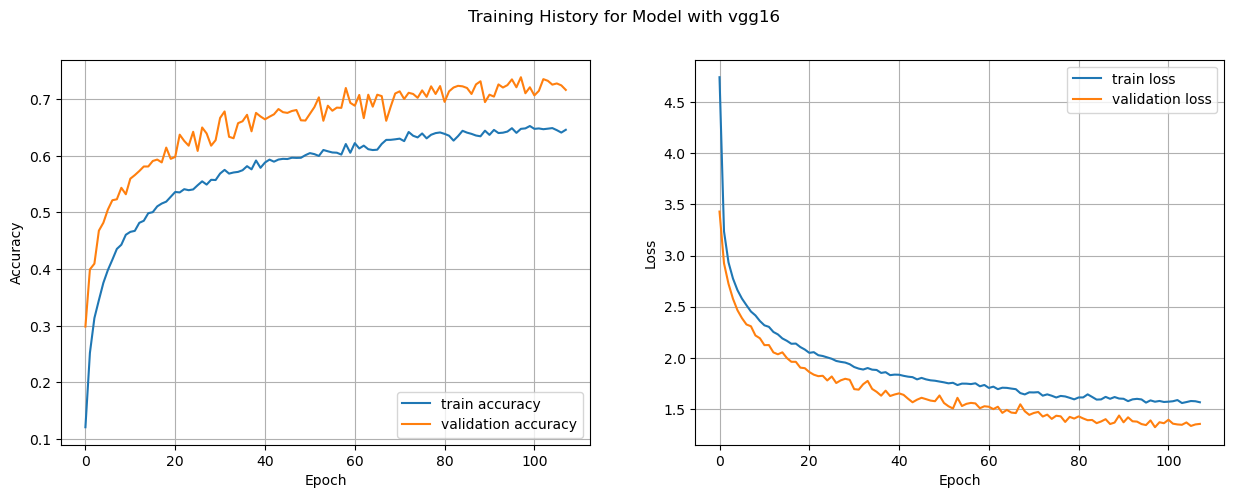

In [6]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=custom_optimizer, loss=custom_loss_with_dynamic_regularization(epoch=0), metrics=['accuracy'])
    

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Define TensorBoard callback
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + base_model.name
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with validation data and early stopping
h = model.fit(
    train_generator,
    epochs=epoch,  # Adjust as needed
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, tensorboard_callback, dynamic_regularization_callback]
)

# Save the model or store the results for later comparison
model.save('./models/full_custom_loss_model_with_' + base_model.name + '_with_validation_early_stopping.h5')

# Plot and save the training history as a PDF
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
# plt.ylim([0, 1])
plt.legend(loc='upper right')

plt.suptitle('Training History for Model with ' + base_model.name)
plt.savefig('./results/full_cutom_loss_training_history_' + base_model.name + '.pdf')
plt.show()